# OOD detection applied to Hallucination Detection

 The goal is to predict if an INPUT prompt  is going to produce an hallucination or not (using OOD detection methods). For now, we don’t look at the output generated by the model, we may consider this in a second time. Retrieve ID samples:  To do this, take a general (easy) QA dataset containing questions along with their true hallucination-free answers. Feed the questions to the model. Let the model generate responses and check if the a given generated response is the same as the real hallucination-free answer. All the correct generated responses will be considered ID. More precisely, the ID dataset will consist of the embeddings of the last token of the last layer of the input (or maybe middle layer) of the correct generated responses.  Test a new sample to see if this is going to be OOD=hallucination: Take another dataset containing questions susceptible to trigger hallucinations along with the true hallucination-free answers (or no answer if the model cannot know the answer by any way and all response that the model might produce will necessarily be hallucinated). Feed a question to the model and let it generate a response. Check by comparing to the hallucination-free answer is that generated response is hallucinated or not. At the same time, apply an OOD detection method on the input question (at the last token last layer) and see if there is a correspondence between a high OOD score and a generated hallucination. 

In [1]:
# import libraries
# -----------------------------------
import torch
import sys
import time 

In [2]:
SEED = 44
BATCH_SIZE = 32
MODEL_NAME =  "meta-llama/Llama-2-7b-chat-hf"
OUTPUT_DIR = "outputs/"

In [ ]:
# Visualize setup 
# -----------------------------------
print(f"Python version: {sys.version}")
print(f"Cuda version: {torch.version.cuda}")
num_gpus = torch.cuda.device_count()
print(f"Number of available de GPU : {num_gpus}")
for i in range(num_gpus):
    print(f"GPU {i + 1} : {torch.cuda.get_device_name(i)}")

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Cuda version: 12.6
Number of available de GPU : 2
GPU 1 : NVIDIA GeForce RTX 4090
GPU 2 : NVIDIA GeForce RTX 4090


In [4]:
# Seed everything
# -----------------------------------
from utils.general import seed_all
seed_all(SEED)

## Load model

In [5]:
# Load model
# -----------------------------------
from models.llama_loader import load_llama

model, tokenizer = load_llama(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load ID dataset

For the ID general dataset, we are going to use the SQUAD 1.1 dataset: 

***SQuAD 1.1:** Comprises over 100,000 question-answer pairs derived from more than 500 Wikipedia articles. Each question is paired with a specific segment of text (a span) from the corresponding article that serves as the answer.*

In [6]:
# Load ID dataset
# -----------------------------------
from data.squad_loader import load_id_fit_dataset

id_fit_dataset = load_id_fit_dataset()
id_fit_dataset = id_fit_dataset.shuffle(SEED) 
id_fit_dataset = id_fit_dataset.slice(idx_start=0, idx_end=10000)
id_fit_dataset.print_info()


===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 10000
})
Mean ground-truth answer length: 3.19, Max length: 30
Mean context + question length: 129.68, Max length: 497


In [7]:
# Visualize one generation with the ID dataset
# -----------------------------------
from inference.inference_utils import analyze_single_generation, build_prompt, get_layer_output, extract_last_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer, 
    dataset=id_fit_dataset,
    sample_idx=0,
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx  = -1,
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)

========= Analyze one generation  =========
----- Prompt construction: 0.000 sec
----- Tokenization: 0.004 sec
----- Token extraction: 0.389 sec
----- Generation: 0.627 sec
----- Decoding: 0.000 sec
----- Similarity scoring: 0.042 sec

=== Prompt ===
<s>[INST]

Just give the answer, without a complete sentence.           

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST]

=== Sh

## Retrieve ID embeddings

In [8]:
# Retrieve ID embeddings and save results 
# -----------------------------------
from inference.inference_utils import batch_extract_token_activations_with_generation, build_prompt, get_layer_output, extract_last_token_activations
from utils.general import print_time_elapsed

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, generates answers, computes semantic similarity scores, extracts token-level activations,
# and appends the results to a pickle file.
print("\nStart retrieving ID embeddings...")
t0 = time.time()

batch_extract_token_activations_with_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_fit_dataset),
    output_path = OUTPUT_DIR + "id_fit_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,  
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)

t1 = time.time()
print("...end!")
print_time_elapsed(t0, t1, label="ID embeddings: ")


Start retrieving ID embeddings...


100%|██████████| 313/313 [29:31<00:00,  5.66s/it]

...end!
ID embeddings: Time elapsed: 29 min 31 sec



In [23]:
# Free memory 
del id_fit_dataset

## Load OOD/Hallucinations test datasets 

To evaluate the Hallucination detection in question answering using OOD detection methods, we will use datasets in the SQuAD style:

***SQuAD 2.0:** SQuAD 2.0 extends the original **SQuAD 1.1** dataset by adding around 50,000 unanswerable questions. These questions are carefully designed to look similar to answerable ones, making it more challenging for models to determine when there isn’t enough information in the context to provide an answer.*

**Test Dataset Composition** \
Our test set will include two types of samples:
- ***Impossible samples***: Questions that cannot be answered based on the provided context (i.e., the answer is not present in the text). These are taken from the training split of SQuAD 2.0, selecting only the unanswerable questions.
- ***Possible samples***: Questions where the answer is explicitly present in the context. These are drawn from the validation split of SQuAD 1.1. This ensures there is no overlap with the in-distribution (ID) data from the SQuAD 1.1 training split.

**Note on Evaluation Scope**\
Currently, our evaluation focuses on whether the model can answer questions using only the information provided in the input context. We do not test the model’s internal knowledge or ability to answer questions without supporting context. However, this setup closely matches the OOD scenario: if the information is not in the text, the model should recognize and indicate this.

**Additional Dataset: TriviaQA**\
To further test generalization, we will also use the TriviaQA dataset. Like SQuAD, TriviaQA provides question-answering prompts with supporting context. The model must either extract the correct answer from the context or correctly identify when the answer is not present.


In [8]:
# Load test datasets
# -----------------------------------
from data.squad_loader import load_id_test_dataset, load_od_test_dataset

# Load possible test dataset 
id_test_dataset = load_id_test_dataset()
id_test_dataset = id_test_dataset.shuffle(SEED) 
id_test_dataset = id_test_dataset.slice(idx_start=0, idx_end=1000)
id_test_dataset.print_info()

# Load impossible test dataset 
od_test_dataset = load_od_test_dataset()
od_test_dataset = od_test_dataset.shuffle(SEED) 
od_test_dataset = od_test_dataset.slice(idx_start=0, idx_end=1000)
od_test_dataset.print_info()



===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 1000
})
Mean ground-truth answer length: 2.94, Max length: 25
Mean context + question length: 132.44, Max length: 513

===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 1000
})
No valid ground-truth answers to compute length stats.
Mean context + question length: 129.01, Max length: 451


In [10]:
# Visualize one generation with the test impossible dataset
# -----------------------------------
from inference.inference_utils import analyze_single_generation, build_impossible_prompt, get_layer_output, extract_last_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer, 
    dataset=od_test_dataset,
    sample_idx=500,
    build_prompt_fn=build_impossible_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx  = -1,
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)

========= Analyze one generation  =========
----- Prompt construction: 0.000 sec
----- Tokenization: 0.019 sec
----- Token extraction: 0.038 sec
----- Generation: 0.077 sec
----- Decoding: 0.000 sec
----- Similarity scoring: 0.004 sec

=== Prompt ===
<s>[INST]

Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.            

Context:
In the Catholic Church, canon law is the system of laws and legal principles made and enforced by the Church's hierarchical authorities to regulate its external organization and government and to order and direct the activities of Catholics toward the mission of the Church.

Question:
What mission this Canon law directly activities of all Christians towards?

Answer:
[/INST]

=== Shapes ===
Shape - number of tokens: torch.Size([1, 119])
Shape - selected_layer: torch.Size([1, 119, 4096])

=== Generated Answer ===
Mission

=== Ground-truth Answer ===


=== Similarity Scores ===
ROUGE-L F1: 0.0000
Sen

## Retrieve test embeddings 

Test embeddings which may be OOD/Hallucinations.

In [ ]:
# Retrieve test embeddings and save results 
# -----------------------------------
from inference.inference_utils import batch_extract_token_activations, build_prompt, get_layer_output, extract_last_token_activations
from utils.general import print_time_elapsed

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, gextracts token-level activations, and appends the results to a pickle file.
print("\nStart retrieving test impossible embeddings...")
t2 = time.time()
batch_extract_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=od_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(od_test_dataset),
    save_to_pkl = True,
    output_path = OUTPUT_DIR + "od_test_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,  
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="Test impossible embeddings: ")


print("\nStart retrieving test possible embeddings...")
t4 = time.time()
batch_extract_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=id_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_test_dataset),
    save_to_pkl = True,
    output_path = OUTPUT_DIR + "id_test_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,  
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)
t5 = time.time()
print("...end!")
print_time_elapsed(t4, t5, label="Test possible embeddings: ")

In [28]:
# Free memory 
del od_test_dataset 
del id_test_dataset

## Load extracted embeddings 

In [7]:
# Load ID embeddings 
# -----------------------------------
from data.pickle_io import load_pickle_batches
from utils.general import filter_correct_entries

# Load extracted embeddings 
id_fit_embeddings = load_pickle_batches(OUTPUT_DIR + "id_fit_results.pkl")
# Only keep rows with simiar generated and ground-truth answers
id_fit_embeddings = filter_correct_entries(id_fit_embeddings) 
# Concatenate all embeddings 
id_fit_embeddings = torch.cat(id_fit_embeddings['activations'], dim=0) # shape: [N, D]


Loaded 10000 samples from: outputs/id_fit_results.pkl
Size before filtering incorrect samples: 10000.
Size after filtering: 8865. Filtered 1135 samples.


In [ ]:
# Load test embeddings 
# -----------------------------------
from data.pickle_io import load_pickle_batches

# Load extracted possible and impossible embeddings 
od_test_embeddings = load_pickle_batches(OUTPUT_DIR + "id_test_results.pkl")
id_test_embeddings = load_pickle_batches(OUTPUT_DIR + "od_test_results.pkl")
# Concatenate possible and impossible all embeddings 
od_test_embeddings = torch.cat(od_test_embeddings['activations'], dim=0) # shape: [N, D]
id_test_embeddings = torch.cat(id_test_embeddings['activations'], dim=0) # shape: [N, D]

Loaded 1000 samples from: outputs/id_test_results.pkl
Loaded 1000 samples from: outputs/od_test_results.pkl


## Perform DKNN

In [9]:
# Constructs the FAISS index from ID data.
# -----------------------------------
from analysis.dknn import fit_to_dataset
index = fit_to_dataset(id_fit_embeddings, use_gpu=True)

In [14]:
# Compute DKNN scores on test data
# -----------------------------------
from analysis.dknn import score_tensor
k=1000
dknn_scores_id  = score_tensor(index, id_test_embeddings, nearest=k, batch_size=BATCH_SIZE)
dknn_scores_ood = score_tensor(index, od_test_embeddings, nearest=k, batch_size=BATCH_SIZE)

auROC: 0.5213


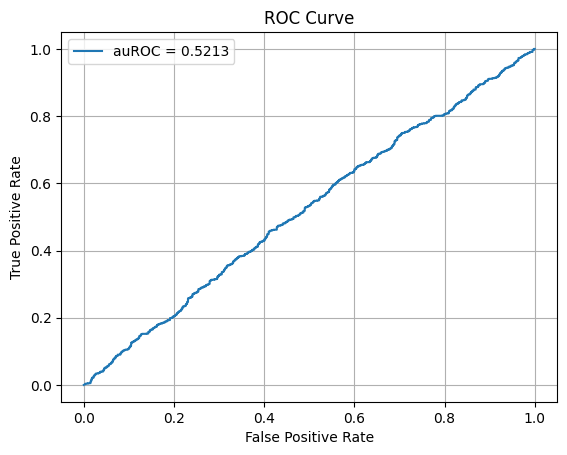

AUROC: 0.5213


In [15]:
# Compute and plot auroc 
# -----------------------------------
from analysis.dknn import compute_auroc
auroc, fpr, tpr, thresholds = compute_auroc(dknn_scores_id, dknn_scores_ood, plot=True)
print(f"AUROC: {auroc:.4f}")

In [ ]:
import time
from typing import Callable, Dict, Any
from transformers import PreTrainedModel, PreTrainedTokenizer  # [1][4][5]
from datasets import Dataset

def analyze_single_generation(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    sample_idx: int = 0,
    build_prompt_fn: Callable[[str, str], str] = None,
    get_layer_output_fn: Callable = None,
    layer_idx: int = -1,
    extract_token_activations_fn: Callable = None,
    **kwargs
) -> Dict[str, Any]:
    """
    Analyze the computation time and output of a single sample through the model pipeline.

    This function processes one sample from the dataset: it builds a prompt, tokenizes it,
    extracts layer activations, generates an answer, decodes the output, computes similarity
    scores with the ground-truth answer, and prints computation times for each step.

    Parameters
    ----------
    model : PreTrainedModel
        The Hugging Face transformer model (e.g., LLaMA, GPT-2).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The Hugging Face dataset containing context, question, and answers fields.
    sample_idx : int, optional
        Index of the sample to analyze (default is 0).
    build_prompt_fn : Callable[[str, str], str], optional
        Function to build a prompt from context and question.
    get_layer_output_fn : Callable = None,
        Function to extract the output of a specific model layer.
    layer_idx : int, optional
        Index of the transformer layer to extract activations from (default is -1 for last layer).
    extract_token_activations_fn : Callable = None,
        Function to extract token activations from a model layer.
    **kwargs :
        Additional keyword arguments passed to extract_token_activations_fn.
    Returns
    -------
    Dict[str, Any]
        Dictionary containing prompt, generated answer, ground-truth answer, similarity scores,
        and computation times for each step.
    """
    sample = dataset[sample_idx]

    print("========= Analyze one generation  =========")
    times = {}

    # Prompt construction
    t0 = time.time()
    prompt = build_prompt_fn(sample["context"], sample["question"])
    answer = sample["answers"]['text']
    times['prompt_construction'] = time.time() - t0
    print(f"----- Prompt construction: {times['prompt_construction']:.3f} sec")

    # Tokenization
    t1 = time.time()
    inputs = tokenizer(prompt, truncation=True, padding=True, return_tensors="pt").to(model.device)
    times['tokenization'] = time.time() - t1
    print(f"----- Tokenization: {times['tokenization']:.3f} sec")

    # Layer output extraction
    t2 = time.time()
    selected_layer = get_layer_output_fn(model, inputs, layer_idx)
    times['layer_output'] = time.time() - t2
    print(f"----- Token extraction: {times['layer_output']:.3f} sec")

    # Token activations extraction
    t3 = time.time()
    selected_token_vecs = extract_token_activations_fn(
        selected_layer,
        inputs["attention_mask"],
        device=selected_layer.device,
        **kwargs
    )
    times['token_activations'] = time.time() - t3

    # Generation
    t4 = time.time()
    output_ids = generate_answers(model, inputs, tokenizer)
    times['generation'] = time.time() - t4
    print(f"----- Generation: {times['generation']:.3f} sec")

    # Decoding
    t5 = time.time()
    prompt_len = len(inputs["input_ids"][0])
    generated_answer_ids = output_ids[0][prompt_len:]
    generated_answer = tokenizer.decode(generated_answer_ids, skip_special_tokens=True).strip()
    times['decoding'] = time.time() - t5
    print(f"----- Decoding: {times['decoding']:.3f} sec")

    # Similarity scoring
    t6 = time.time()
    rouge_l_score = rouge_l_simScore_fn(generated_answer, answer)
    sbert_sim = sentence_bert_simScore_fn(generated_answer, answer)
    is_correct = (rouge_l_score >= 0.5) or (sbert_sim >= 0.4)
    times['similarity_scoring'] = time.time() - t6
    print(f"----- Similarity scoring: {times['similarity_scoring']:.3f} sec")

    # Display information
    print("\n=== Prompt ===")
    print(prompt)
    print("\n=== Shapes ===")
    print(f"Shape - number of tokens: {inputs['input_ids'].shape}")
    print(f"Shape - selected_layer: {selected_layer.shape}")
    print("\n=== Generated Answer ===")
    print(generated_answer)
    print("\n=== Ground-truth Answer ===")
    print(answer)
    print("\n=== Similarity Scores ===")
    print(f"ROUGE-L F1: {rouge_l_score:.4f}")
    print(f"Sentence-BERT Cosine Similarity: {sbert_sim:.4f}")
    print(f"Is generated answer correct: {is_correct}")

    return {
        "prompt": prompt,
        "generated_answer": generated_answer,
        "ground_truth_answer": answer,
        "rouge_l_score": rouge_l_score,
        "sbert_score": sbert_sim,
        "is_correct": is_correct,
        "computation_times": times,
        "input_shape": inputs['input_ids'].shape,
        "layer_shape": selected_layer.shape,
        "token_activations": selected_token_vecs,
    }


In [ ]:
# DEBUG: Analyze of feeding 1 input to the model and monitor computation times
# -----------------------------------
import time 
sample_idx = 0
layer_idx = -1
# def visualize_one_generation(dataset):

sample = dataset[sample_idx]

print("========= Analyze one generation  =========")
print("\n=== Computational time analysis ===")
t0 = time.time()
prompt = build_prompt(sample["context"], sample["question"])
answer = sample["answers"]['text']
print(f"----- Prompt construction: {time.time() - t0:.3f} sec")

# Tokenize prompt
t1 = time.time()
inputs = tokenizer(prompt, truncation=True, padding=True, return_tensors="pt").to(model.device)
print(f"----- Tokenization: {time.time() - t1:.3f} sec")

# Make a pass through the model to retrieve activations
t3 = time.time()
selected_layer = get_layer_output_fn(model, inputs, layer_idx) # shape: (batch_size, seq_len, hidden_size)
print(f"----- Token extraction: {time.time() - t3:.3f} sec") 

selected_token_vecs = extract_token_activations_fn(
                selected_layer, 
                inputs["attention_mask"], 
                device=selected_layer.device,
                **kwargs) 

# Generate a response 
output_ids = generate_answers(model, inputs, tokenizer)
print(f"----- Generation: {time.time() - t4:.3f} sec")

# Decode token IDs into text 
t5 = time.time()
prompt_len = len(inputs["input_ids"]) # Length of prompt j
generated_answer_ids = output_ids[prompt_len:] # Remove prompt prefix to isolate the generated answer
generated_answer = tokenizer.decode(generated_answer_ids, skip_special_tokens=True).strip()
print(f"----- Decoding: {time.time() - t5:.3f} sec")

# Compute similarity between ground truth answer and generated response
t6 = time.time()
rouge_l_score = rouge_l_simScore(generated_answer, answer)
sbert_sim = sentence_bert_simScore(generated_answer, answer)
is_correct = (rouge_l_score>= 0.5) or (sbert_sim >= 0.4)
print(f"----- Similarity scoring: {time.time() - t6:.3f} sec")

# Display information
print("\n=== Prompt ===")
print(prompt)
print("\n=== Shapes ===")
print(f"Shape - number of tokens: {inputs['input_ids'].shape}")
print(f"Shape - selected_layer: {selected_layer.shape}")
print("\n=== Generated Answer ===")
print(generated_answer)  
print("\n=== Ground-truth Answer ===")
print(answer)
print("\n=== Similarity Scores ===")
print(f"ROUGE-L F1: {rouge_l_score:.4f}")
print(f"Sentence-BERT Cosine Similarity: {sbert_sim:.4f}")
print(f"Is generated answer correct: {is_correct}")